<a href="https://colab.research.google.com/github/JuniorHZ19/ML/blob/main/convolucionfinal5.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown # *0) ** Instalando libreria(OBLIGATORIO)

!pip install torch torchvision torchaudio

In [2]:
#@markdown # *1) ** Descargando DataSet  de perros y gatos(OBLIGATORIO)
import zipfile

nombre_zip="data_set_dogcat.zip"

directorio_destino="/content/"

!gdown --id 19u9sy2053Ds739lyYSJut6S_k54trLnd -O {nombre_zip}

with zipfile.ZipFile(nombre_zip, 'r') as zip_ref:
    zip_ref.extractall(directorio_destino)



/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19u9sy2053Ds739lyYSJut6S_k54trLnd
To: /content/data_set_dogcat.zip
100% 826M/826M [00:15<00:00, 55.0MB/s]


In [ ]:
import os

# Recorre el directorio  y elmiina los archvios que no tiene las extensioens permitidas
def comprobarExt(directorio):
  # Extensiones permitidas
  extensiones_permitidas = {".jpg", ".jpeg", ".png"}
  for root, dirs, files in os.walk(directorio):
    for file in files:
        # Obtiene la extensión del archivo
        _, extension = os.path.splitext(file)

        # Verifica si la extensión no está en la lista de extensiones permitidas y elimina el archivo
        if extension.lower() not in extensiones_permitidas:
            archivo_a_eliminar = os.path.join(root, file)
            os.remove(archivo_a_eliminar)
            print(f"Se eliminó: {archivo_a_eliminar}")

# Cambia nombre de cada archivo dentro del directorio a un valor secuencial

def cambiarNombre(directorio,subfijo):
  archivos_en_directorio = os.listdir(directorio)
  for i, archivo in enumerate(archivos_en_directorio, start=1):
    # Construir el nuevo nombre del archivo
    nuevo_nombre = f"{subfijo}{i}{os.path.splitext(archivo)[1]}"

    # Ruta completa del archivo antiguo y nuevo
    ruta_antigua = os.path.join(directorio, archivo)
    ruta_nueva = os.path.join(directorio, nuevo_nombre)

    # Cambiar el nombre del archivo
    os.rename(ruta_antigua, ruta_nueva)
    print(f"Se cambió el nombre de {ruta_antigua} a {ruta_nueva}")

#Obtiene la cantidad de elemntos que tiene la carpeta

def len_directorio(directorio):
    cantidad_elementos = sum(1 for elemento in os.listdir(directorio) if os.path.isfile(os.path.join(directorio, elemento)))
    return cantidad_elementos


#----------------------------------------------------------------------------------------------

directorios={
     "gato":"/content/PetImages/Cat",
     "perro":"/content/PetImages/Dog",
}

for etiqueta,directorio in(directorios.items()):
  lista_directorio=os.listdir(directorio)
  comprobarExt(directorio)
  cambiarNombre(directorio,etiqueta)





In [39]:
#@markdown # *1) ** Creacion de el csv de los path y clases(OBLIGATORIO)

import os
import cv2
import pandas as pd


#Valida si la imagen se puede leer usando  cv2 si no se puede leer se elimina

def validarLecturaImg(directorio,lista):
 for ruta in(lista):
   imagen=cv2.imread(directorio+ruta)
   if  imagen is None:
    os.remove(directorio+ruta)
    print(f"No se pudo leer y se elimino archivo:{directorio+ruta}")

def crear_paths_csv(directorio_base,clases_lista,clases,nombre_archivo):

   columnas=["path","etiqueta"]
   datos_csv=[]

   for dir_base,dir,clase in  zip(directorio_base,clases_lista,clases):

    for path  in (dir):

     datos_csv.append([dir_base+path ,clase])


   df_lista=pd.DataFrame(datos_csv,columns=columnas)
   df_lista.to_csv(nombre_archivo,index=False)
   print("Csv Creado")

#---------------------------------------------------------------------------------

directorios={
     "gato":["/content/PetImages/Cat/",0],
     "perro":["/content/PetImages/Dog/",1],
}

listas_directorios=[]
listas_listas_directorios=[]
listas_clases=[]
#vamos a recorrer el dicionario y validar ruta por ruta si se puede leer sino se elminara
#vamos guaradno al mismo tiempo 3 listas, los directorios , listas de paths de los directiros y de las clases ,para usarlo luego usarlo al crear el csv
for etiqueta,[directorio,clase] in(directorios.items()):

  lista_paths=os.listdir(directorio)
  validarLecturaImg(directorio,lista_paths)

  listas_directorios.append(directorio)
  listas_listas_directorios.append(lista_paths)
  listas_clases.append(clase)

#Tomamos el minimo tamaño dentro de las lista de cada clase
tamaño_minimo = min(len(arr) for arr in listas_listas_directorios)

#Vamos a emparejar todas las listas con un tamaño igual que sea la del minimo tamaño de todas,esto para tener un set de datos parejo por cada clase
Reducido_lista_paths=[]

for listas in(listas_listas_directorios):
   Reducido_lista_paths.append(listas[:tamaño_minimo])


#La funcion que creamos para podre crear nuestro csv , con los parametros antes calucaldos que son 3 listas y el nombre del csv

Dataset_csv="Data_set.csv" #nomble que tendla nuestlo csv
crear_paths_csv(listas_directorios,Reducido_lista_paths,listas_clases,Dataset_csv)


Csv Creado


Csv Creado


In [40]:
#@markdown # *2) ** Creacion de clase DATASET(OBLIGATORIO)
import torch
from torch.utils.data import Dataset,DataLoader
import pandas as pd

import sklearn
import cv2
from PIL import Image


class MiDataSet(Dataset):

  def __init__(self,csv_file, transform=None):


     self.data=pd.read_csv(csv_file)

     self.x=self.data["path"]
     self.y=self.data["etiqueta"]

     self.transform=transform

     self.samples=self.data["path"].shape[0]


  def __getitem__(self,id):

    rut_imagen=self.x[id]
    imagen=cv2.imread(rut_imagen)
    etiqueta=self.y[id]

    if imagen is None:
     print(f"No se pudo cargar la imagen en {rut_imagen}")


    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)


    if self.transform:
      imagen_rgb = self.transform(imagen_rgb)

    return imagen_rgb,etiqueta


  def __len__(self):
   return self.samples





In [ ]:

#@markdown # *3) ** Separacion dos archivos difentes para entrenamietno y prueba(OBLIGATORIO)

from sklearn.model_selection import train_test_split

misdatos=pd.read_csv("/content/Data_set_paths.csv")
# Separo mis datos en entrenamiento y test

etiquetas=misdatos["etiqueta"]
datos_entrenamiento, datos_evaluacion = train_test_split(misdatos, test_size=0.3, random_state=42,stratify=etiquetas)


# Guardar los dos conjuntos en archivos CSV separados
datos_entrenamiento.to_csv("/content/datos_entrenamiento.csv", index=False)
datos_evaluacion.to_csv("/content/datos_evaluacion.csv", index=False)




In [ ]:
#@markdown # *2) ** Mostrar 20 muestras(Opcional)
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image


# Definir transformaciones
transformaciones = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100))
])

# Crear dataset y DataLoader
muestra = MiDataSet("/content/datos_entrenamiento.csv", transformaciones)
data_muestra = DataLoader(muestra, batch_size=20, shuffle=True)

# Obtener el primer lote
primer_lote = next(iter(data_muestra))
tensor_imagenes, tensor_etiquetas = primer_lote

# Mapeo de etiquetas numéricas a etiquetas de texto
mapeo_etiquetas = {0: 'gato', 1: 'perro'}
etiquetas_texto = [mapeo_etiquetas[item.item()] for item in tensor_etiquetas]

# Crear una figura y subgráficos
fig, axs = plt.subplots(4, 5, figsize=(20, 20))

# Iterar sobre las imágenes del lote
for i in range(4):
    for j in range(5):
        idx = i * 5 + j
        imagen = tensor_imagenes[idx].permute(1, 2, 0)
        etiqueta_texto = etiquetas_texto[idx]

        # Mostrar la imagen en el subgráfico correspondiente
        axs[i, j].imshow(imagen)
        axs[i, j].set_title(etiqueta_texto)
        axs[i, j].axis('off')

plt.show()


In [ ]:
import sklearn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

transformaciones = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Resize((100, 100))
])

mis_datos_entrenamiento=MiDataSet("/content/datos_entrenamiento.csv",transform=transformaciones)

mis_datos_test=MiDataSet("/content/datos_evaluacion.csv",transform=transformaciones)


data_por_lote_entrenamiento=DataLoader(mis_datos_entrenamiento,batch_size=100,shuffle=True)

data_por_por_lote_test=DataLoader(mis_datos_test,batch_size=100,shuffle=True)







In [ ]:
import torch.nn as nn
import torch.nn.functional as F



class RedConvolucional(nn.Module):

   def __init__(self):
    super(RedConvolucional,self).__init__()

#Red convolulcional

    self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3, stride=1)

    self.conv2=nn.Conv2d(in_channels=32,out_channels=40,kernel_size=3, stride=2)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3=nn.Conv2d(in_channels=40,out_channels=48,kernel_size=3, stride=2)

    self.flatten=nn.Flatten()

#Red fully conected o multicapa convecional

    self.capa_oculta1=nn.Linear(11*11*48,500)
    self.capa_oculta2=nn.Linear(500,400)
    self.capa_salida=nn.Linear(400,2)


   def forward(self,x):
    #Capa convolucionales
     x=self.conv1(x)
     x=F.relu(x)

     x=self.conv2(x)
     x=F.relu(x)
     x=self.maxpool1(x)

     x=self.conv3(x)
     x=F.relu(x)

     x=self.flatten(x)

#Capa fully conected
     x=self.capa_oculta1(x)
     x=F.relu(x)
     x=self.capa_oculta2(x)
     x=F.relu(x)

     x=self.capa_salida(x)
     #x=F.softmax(x,dim=1)
     return x


In [ ]:

import torch
if torch.cuda.is_available():
    print("CUDA está disponible.")
    device = torch.device("cuda")
else:
    print("CUDA no está disponible. Se utilizará la CPU.")
    device = torch.device("cpu")
#funcion clasificador:
def clasificador(y_pred_test):
 max_values_tensor=torch.empty((0,),dtype=torch.float32,device=device)

 for tensor in y_pred_test:

   max_values,max_indices=torch.max(tensor,dim=0)
   max_values_tensor=torch.cat((max_values_tensor,max_indices.unsqueeze(0)))

 return max_values_tensor

#funcion acutity:
def accurity(y_test,y_real):
   correctos=0
   for predicho, real in zip(y_test, y_real):
    if predicho==real:
     correctos+=1
   return correctos/len(y_test)


import torch.optim as optim


ModeloRC=RedConvolucional()

ModeloRC=ModeloRC.to(device)
criterio=nn.CrossEntropyLoss()

optimizer=optim.Adam(ModeloRC.parameters(),lr=0.00001)

epochs=15

for epoch in range(epochs):
 total_train_loss = 0.0
 num_train_batches = len(data_por_lote_entrenamiento)
 ModeloRC.train()
 for i,(xi,yi) in enumerate(data_por_lote_entrenamiento):
    xi,yi=xi.to(device),yi.to(device)
    y_predict=ModeloRC(xi)
    loss=criterio(y_predict,yi)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_train_loss+=loss.item()

 ModeloRC.eval()
 with torch.no_grad():
  total_test_accuracy = 0.0
  num_test_batches = len(data_por_por_lote_test)
  for i,(xi,yi) in enumerate(data_por_por_lote_test):
       xi,yi=xi.to(device),yi.to(device)
       y_predict_test=ModeloRC(xi)
       y_predic_test_clasificado=clasificador(yi)
       Precision=accurity(y_predic_test_clasificado,yi)
       total_test_accuracy += Precision

 avg_test_accuracy = total_test_accuracy / num_test_batches
 avg_train_loss=total_train_loss/num_train_batches

 print(f'Epoca[{epoch+1}], Perdida: {avg_train_loss:.4f},Accuryty:{avg_test_accuracy:.4f}')

torch.save(ModeloRC.state_dict(), 'modelo_gatoperro2.pt')


CUDA está disponible.
Epoca[1], Perdida: 0.6563,Accuryty:0.6680
Epoca[2], Perdida: 0.6346,Accuryty:0.6653
Epoca[3], Perdida: 0.6281,Accuryty:0.6680
Epoca[4], Perdida: 0.6153,Accuryty:0.6680
Epoca[5], Perdida: 0.5964,Accuryty:0.6680
Epoca[6], Perdida: 0.5785,Accuryty:0.6735
Epoca[7], Perdida: 0.5669,Accuryty:0.6653
Epoca[8], Perdida: 0.5572,Accuryty:0.6708
Epoca[9], Perdida: 0.5508,Accuryty:0.6708
Epoca[10], Perdida: 0.5456,Accuryty:0.6680
Epoca[11], Perdida: 0.5385,Accuryty:0.6680
Epoca[12], Perdida: 0.5324,Accuryty:0.6680
Epoca[13], Perdida: 0.5268,Accuryty:0.6680
Epoca[14], Perdida: 0.5210,Accuryty:0.6625
Epoca[15], Perdida: 0.5149,Accuryty:0.6680


CUDA está disponible.


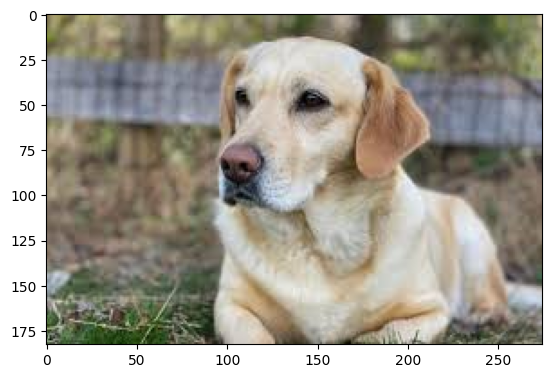

RedConvolucional(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 40, kernel_size=(3, 3), stride=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(40, 48, kernel_size=(3, 3), stride=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (capa_oculta1): Linear(in_features=5808, out_features=500, bias=True)
  (capa_oculta2): Linear(in_features=500, out_features=400, bias=True)
  (capa_salida): Linear(in_features=400, out_features=2, bias=True)
)
tensor([[0.5908, 0.4092]], device='cuda:0')


In [ ]:
import cv2
from google.colab import files
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
if torch.cuda.is_available():
    print("CUDA está disponible.")
    device = torch.device("cuda")
else:
    print("CUDA no está disponible. Se utilizará la CPU.")
    device = torch.device("cpu")

# Obtener el nombre del archivo y cargar la imagen

img_path = "/content/prr.jpg"
imagen=cv2.imread(img_path)
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

plt.imshow(imagen_rgb)
plt.show()

transformacion = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

])

imagen_tensor = transformacion(imagen_rgb)
imagen_tensor=imagen_tensor.to(device)



# Carga los pesos del modelo entrenado
ModeloRC= RedConvolucional()
state_dict = torch.load('/content/modelo_gatoperro2.pt')

# Load the state dictionary into the model
ModeloRC.load_state_dict(state_dict)
ModeloRC = ModeloRC.to('cuda')
print(ModeloRC)
# Asegúrate de poner el modelo en modo de evaluación si es necesario

ModeloRC.eval()
with torch.no_grad():
  predicciones = ModeloRC(imagen_tensor.unsqueeze(0))
  probabilidades = F.softmax(predicciones, dim=1)
  # Obtener la clase predicha (índice de la probabilidad más alta)
  print(probabilidades)







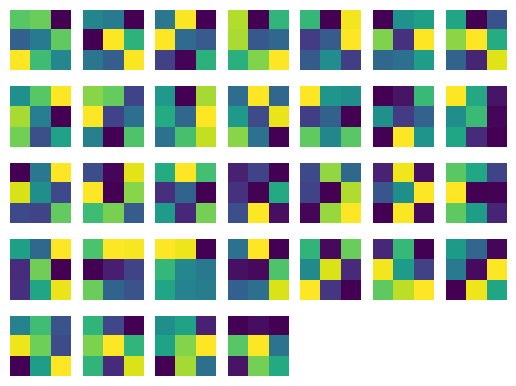

In [ ]:
# Assuming ModeloRC is an instance of your RedConvolucional model
ModeloRC = RedConvolucional()

import matplotlib.pyplot as plt
import numpy as np
def visualize_conv_layer_weights(layer, cmap='viridis'):
    weights = layer.weight.data.cpu().numpy()
    num_filters = weights.shape[0]

    # Determine the number of rows and columns for subplots
    rows = int(np.sqrt(num_filters))
    cols = num_filters // rows + 1

    # Visualize the weights of each filter
    for i in range(num_filters):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(weights[i, 0], cmap=cmap)
        plt.axis('off')

    plt.show()

# Load the state dictionary into the model
state_dict = torch.load('/content/modelo_gatoperro2.pt')
ModeloRC.load_state_dict(state_dict)
ModeloRC = ModeloRC.to('cuda')

# Visualize the weights of each convolutional layer

visualize_conv_layer_weights(ModeloRC.conv1)# poner que capa quiers visuzlar

